In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans as KMeansSk

from models import *
from coreset import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data/bio_train.csv', header=None)

X = data.loc[:, 2:]
true_labels = data.loc[:, 0]

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Lloyd’s algorithm for k-Means Clustering 

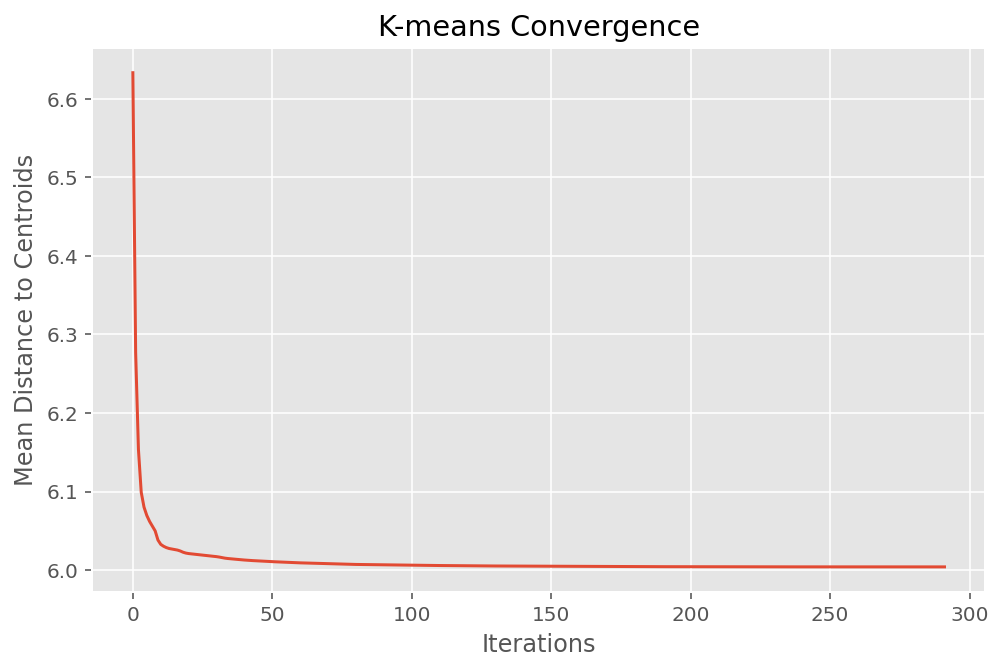

NMI: 0.18939551549451972
Runtime: 142.96158695220947 sec
Distance Computations: 6511527000
Iterations: 292


In [28]:
kmeans = KMeans(k=153)
start_time = time.time()
labels = kmeans.fit_predict(X)
end_time = time.time()

nmi = normalized_mutual_info_score(true_labels, labels)
runtime = end_time - start_time
distance_computations = kmeans.distance_computations
iterations = kmeans.iterations

plt.plot(kmeans.convergence_history)

plt.xlabel('Iterations')
plt.ylabel('Mean Distance to Centroids')
plt.title('K-means Convergence')
plt.show()

print(f'NMI: {nmi}')
print(f'Runtime: {runtime} sec')
print(f'Distance Computations: {distance_computations}')
print(f'Iterations: {iterations}')

# k-Means with Locality Sensitive Hashing (LSH)

In [6]:
params_combinations = [
    (nh, hs, cm)
    for nh in [4, 8, 10]
    for hs in [4, 8, 10]
    for cm in ['AND', 'OR']
]

best_params = None
best_nmi = 0
k = 153

np.random.seed(420)

for params in params_combinations:
    nh, hs, cm = params
    kmeans = KMeansLSH(k=k, num_hashes=nh, hash_size=hs, combination_method=cm)
    labels = kmeans.fit_predict(X)
    nmi = normalized_mutual_info_score(true_labels, labels)
    if nmi > best_nmi:
        best_nmi = nmi
        best_params = params

print('')
print('Best hyperparameters:', best_params)
print('Best NMI:', best_nmi)


Best hyperparameters: (4, 4, 'AND')
Best NMI: 0.18920316098638298


100%|██████████| 5/5 [12:54<00:00, 154.93s/it]


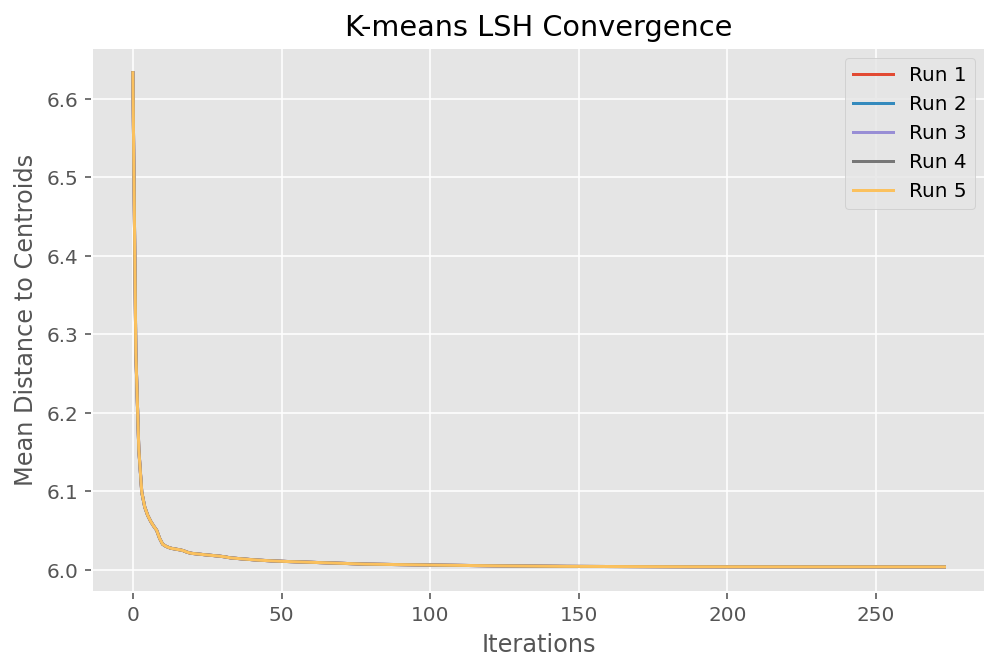

Average NMI: 0.18920316098638298
Average Runtime: 154.87499208450316 sec
Average Distance Computations: 6110131500.0
Average Iterations: 274.0


In [7]:
n_runs = 5
num_hashes, hash_size, combination_method = best_params

nmi_scores = []
runtimes = []
distance_computations = []
iterations = []

np.random.seed(420)

for _ in tqdm(range(n_runs)):
    kmeans = KMeansLSH(k=k, num_hashes=num_hashes, hash_size=hash_size, combination_method=combination_method)
    start_time = time.time()
    labels = kmeans.fit_predict(X)
    end_time = time.time()

    nmi = normalized_mutual_info_score(true_labels, labels)
    nmi_scores.append(nmi)
    runtimes.append(end_time - start_time)
    distance_computations.append(kmeans.distance_computations)
    iterations.append(kmeans.iterations)

    plt.plot(kmeans.convergence_history, label=f'Run {_+1}')

plt.xlabel('Iterations')
plt.ylabel('Mean Distance to Centroids')
plt.title('K-means LSH Convergence')
plt.legend()
plt.show()

avg_nmi = np.mean(nmi_scores)
avg_runtime = np.mean(runtimes)
avg_distance_computations = np.mean(distance_computations)
avg_iterations = np.mean(iterations)

print(f'Average NMI: {avg_nmi}')
print(f'Average Runtime: {avg_runtime} sec')
print(f'Average Distance Computations: {avg_distance_computations}')
print(f'Average Iterations: {avg_iterations}')

# k-means with coresets

In [13]:
k = 153
n_runs = 5

np.random.seed(420)

for m in [1000, 10000]:
    nmi_scores = []
    runtimes = []
    distance_computations = []
    iterations = []
    for _ in tqdm(range(n_runs)):
        cs = Coreset(X, m)
        coreset, weights = cs.sample_coreset()

        kmeans = KMeansSk(n_clusters=k)
        start_time = time.time()
        kmeans.fit(coreset, sample_weight=weights)
        run_time = time.time() - start_time
        y_pred = kmeans.predict(X)

        nmi = normalized_mutual_info_score(true_labels, y_pred)

        nmi_scores.append(nmi)
        runtimes.append(run_time)
        distance_computations.append(kmeans.n_iter_ * k * m)
        iterations.append(kmeans.n_iter_)

    print(f'M = {m}', end='\n\n')
    print(f'Average NMI: {np.mean(nmi_scores)}')
    print(f'Average Runtime: {np.mean(runtimes)} sec')
    print(f'Average Distance Computations: {np.mean(distance_computations)}')
    print(f'Average Iterations: {np.mean(iterations)}', end='\n\n')

  0%|          | 0/5 [00:00<?, ?it/s]

M = 1000

Average NMI: 0.16182163367992647
Average Runtime: 0.5798985004425049 sec
Average Distance Computations: 1621800.0
Average Iterations: 10.6



100%|██████████| 5/5 [00:23<00:00,  4.77s/it]

M = 10000

Average NMI: 0.18113596184418204
Average Runtime: 4.5850992679595945 sec
Average Distance Computations: 68850000.0
Average Iterations: 45.0



In [15]:
k = 153
n_runs = 10

np.random.seed(420)

for m in [1000, 10000]:
    nmi_scores = []
    for _ in tqdm(range(n_runs)):
        cs = Coreset(X, m)
        coreset, weights = cs.sample_coreset()

        kmeans = KMeansSk(n_clusters=k)
        kmeans.fit(coreset, sample_weight=weights)
        y_pred = kmeans.predict(X)

        nmi = normalized_mutual_info_score(true_labels, y_pred)

        nmi_scores.append(nmi)

    print(f'M = {m}', end='\n\n')
    print(f'Variance of NMI: {np.var(nmi_scores)}', end='\n\n')

  0%|          | 0/10 [00:00<?, ?it/s]

M = 1000

Variance of NMI: 6.417183484397636e-06



100%|██████████| 10/10 [00:51<00:00,  5.12s/it]

M = 10000

Variance of NMI: 1.982535017772117e-06

